# Person Re-identification Project

**Liming Zhao**, Xi Li, Jingdong Wang, and Yueting Zhuang. “Deeply-Learned Part-Aligned Representations for Person Re-Identification.” Proceedings of the International Conference on Computer Vision (ICCV), 2017.

Contact: Liming Zhao (zlmzju@gmail.com)

## The interface class for feature extraction

In [1]:
import reid #my code in the reid directory
import numpy as np

In [2]:
DATA_DIR='./data/'

In [3]:
class PartNet(reid.DataProcessor):
    def __init__(self,data_dir,feat_dir='./feature/'):
        self.data_dir=data_dir
        self.feat_folder=feat_dir
        self.image_list=self.readDir(data_dir)
        self.score_list=[]
        self.extractor=None
        
    def extract_features(self, proto_name, model_name, gpu_id):
        ###################init self.net##############################
        if self.extractor is None:
            self.extractor=reid.Extractor(gpu_id, proto_name, model_name)
        ###################dataset###############################
        print 'Start extracting features for %d images in %s'%(len(self.image_list),self.data_dir)
        ################extract features#########################
        image_features=self.extractor.extract_features(self.image_list)
        #################save to txt files#####################
        self.save_features(image_features)
        image_path=self.image_list[0][:self.image_list[0].rfind('/')]
        print 'Features are saved to %s folder'%(self.feat_folder)
        
    def load_features(self,rank=True):
        image_features=[]
        for image_name in self.image_list:
            feat_name=self.save_name(image_name)
            feature=np.loadtxt(feat_name)
            image_features.append(feature)
        print 'Successfully loaded %d features'%(len(image_features))
        if rank:
            score_list=self.rank_features(image_features,image_features)
            self.score_list=score_list
            return self.image_list, self.score_list
        else:
            return image_features

## Extract or Load the Features
0. Extracted Features
Each image corresponds to a feature file (*.txt) in the same folder structure and filename.

0. Feature file format
The feature file contains 512 float numbers, which indicates a 512-d feature vector for the image.


#### Step by Step Tutorial
0. Init the PartNet feature extractor with the dataset directory
0. Then we will obtain a list of all image filenames in the given directory.

In [4]:
processor=PartNet(data_dir=DATA_DIR)
print 'Some examples of the image_list:\n', processor.image_list[:3]

Some examples of the image_list:
['./data/01_0010_01.jpg', './data/01_0010_02.jpg', './data/01_0010_03.jpg']


Extract features using the given models, and they are saved as `txt` files in the `feature` folder

**uncomment the code of extract_features to extract the features**

In [5]:
proto_name='../models/demo/test.prototxt'
model_name='../models/demo/demo.caffemodel'
processor.extract_features(proto_name, model_name, gpu_id=0)

Start extracting features for 93 images in ./data/
Features are saved to ./feature/ folder


0. If we already have the `txt` features, use the `load_features` function to load them.
0. If `rank=True`, we will use every image as a query, and rank all the images by calculating the Euclidean distance between the features

In [6]:
image_list, score_list=processor.load_features(rank=True)

Successfully loaded 93 features


In [7]:
print 'The shape of score_list:', len(score_list),'list, each contains',len(score_list[0]), 'ranked scores'
print 'An example of the score_list for the second query:\n', score_list[1][:5]

The shape of score_list: 93 list, each contains 93 ranked scores
An example of the score_list for the second query:
[0.79150819667777428, 1.0, 0.53664493501140276, 0.69385520003313705, 0.76380277264156382]


## Show the ranked results

### The demo show interface
- The `image_list` consists of N image filenames
- We got the `score_list` for all the images in the `image_list`.

In [8]:
class Demo():    
    def __init__(self, image_list, score_list):
        self.image_list=image_list
        self.score_list=score_list
        
    def show_result(self, query_id, ranked_list,topk=5, debug=False):
        import matplotlib.pyplot as plt
        fig=plt.figure(figsize=(12,6))
        query_name=self.image_list[query_id]
        ax=plt.subplot(1,topk+2,1);
        ax.tick_params(labelbottom='off', labelleft='off')
        reid.Plotter.show_image(query_name)
        title_name=reid.Plotter.person_id(query_name)
        plt.title(title_name,fontsize=10)
        if debug:
            print 'Query filename: ',query_name
            print 'Ranked gallery filename:'
        #show the topk ranking results
        for i in range(topk):
            ax=plt.subplot(1,topk+2,i+3);
            ax.tick_params(labelbottom='off', labelleft='off')
            rank_idx=ranked_list[i]
            ranked_filename=image_list[rank_idx]
            score=self.score_list[query_id][rank_idx]
            if debug:
                print ranked_filename
            plt.title('%.4f'%score,fontsize=10)
            reid.Plotter.show_image(ranked_filename)
        plt.show()
        
    def select_show(self,rand_num=10):
        all_query_list=range(len(self.score_list))
        #randomly select the queries to show
        random_list=np.random.choice(all_query_list,rand_num, replace=False)
        print 'Randomly show %d results for the query ids in all_query_list (total number is %d)'%(len(random_list),len(all_query_list))
        print 'Some examples of the query_list', random_list[:10]
        return random_list, all_query_list
    
    def show_demo(self, query_list, topk=5, debug=False):
        for query_id in query_list:
            ranked_list=np.argsort(self.score_list[query_id])[::-1]
            cur_score_list=np.sort(self.score_list[query_id])[::-1]
            self.show_result(query_id,ranked_list[1:],topk, debug) #ignore the top-1 (always the query itself)

In [9]:
demo=Demo(image_list,score_list)

### Show the ranked results
Based on the image_list and score_list

In [10]:
random_list, all_query_list =demo.select_show(rand_num=5)

Randomly show 5 results for the query ids in all_query_list (total number is 93)
Some examples of the query_list [86 24  4 49  8]


### Plot the ranked images
0. Show the topk ranked results
0. Use `debug=True` to show the image filenames

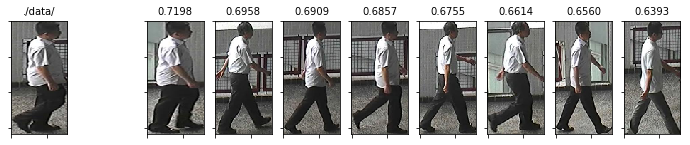

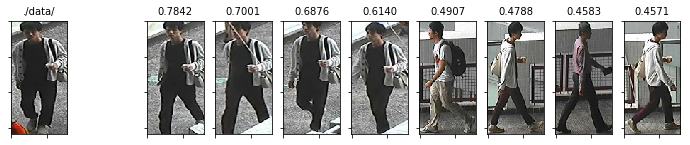

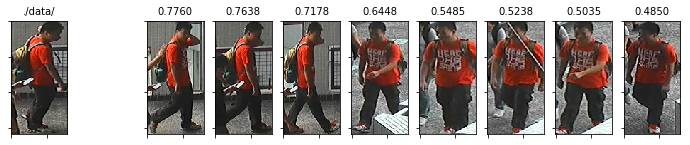

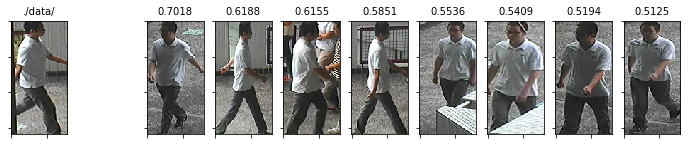

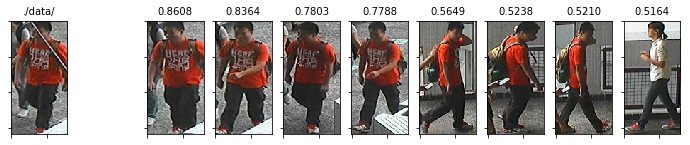

In [11]:
demo.show_demo(random_list, topk=8, debug=False)

### Show the part map

Show the part maps for 5 image files
./data/01_0019_04.jpg


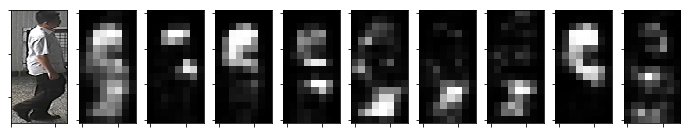

./data/01_0012_06.jpg


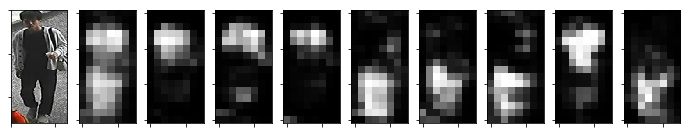

./data/01_0010_05.jpg


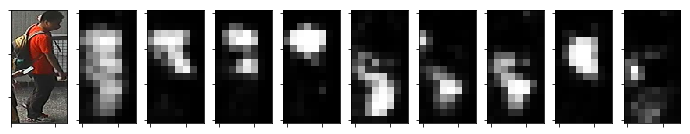

./data/01_0015_02.jpg


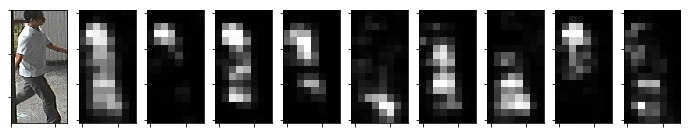

./data/01_0010_09.jpg


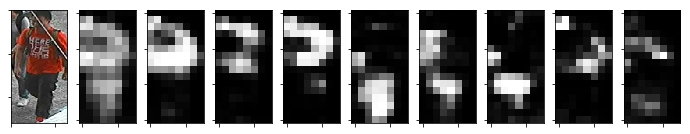

In [12]:
file_names=[image_list[idx] for idx in random_list]
print 'Show the part maps for %d image files'%(len(file_names))
reid.Plotter.show_maps(processor.extractor,file_names)